#Preprocessing: Form X (Input features) and Y (target variable) and if required, normalize the variables in X

In [464]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

In [465]:
#Load training data from local drive
from google.colab import files
uploaded = files.upload()
import io
real_estate= pd.read_csv(io.BytesIO(uploaded['Real estate.csv']))
real_estate.head(3)

Saving Real estate.csv to Real estate (9).csv


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3


In [466]:
real_estate.shape

(414, 8)

In [467]:
real_estate.set_axis(['No','tdate','hage','dmrt','stores','lati','long','hprice'],axis=1,inplace=True)#Renaming the features
real_estate.head(1)

,No,tdate,hage,dmrt,stores,lati,long,hprice
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9


In [468]:
X=real_estate.loc[:,"hage":"stores"] # Feature selection, Drop No, transaction date and location attributes that are not supposed to influence (correlated to the target value)
X.head(1)

,hage,dmrt,stores
0,32.0,84.87882,10


In [469]:
Y=real_estate.iloc[:,-1]
Y.head(3)

0    37.9
1    42.2
2    47.3
Name: hprice, dtype: float64

###Feature Normalization

In [470]:
def feature_normalize(X, mean=np.zeros(1), std=np.zeros(1)):
    X = np.array(X)
    if len(mean.shape) == 1 or len(std.shape) == 1:
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0, ddof=1)

    X = (X - mean)/std
    return X, mean, std

In [471]:
X_norm, mu, sigma = feature_normalize(X)
print (X.head(1),"\n", X_norm[0],"\n",mu,"\n",sigma)

   hage      dmrt  stores
0  32.0  84.87882      10 
 [ 1.25411095 -0.79153734  2.00498156] 
 [  17.71256039 1083.88568891    4.0942029 ] 
 [  11.39248453 1262.10959541    2.94556181]


#Normal Equations
$\theta = (X^TX)^{-1}X^Ty$



In [475]:
def normal_eqn(X, Y):
    inv = np.linalg.pinv(X.T.dot(X))
    theta = inv.dot(X.T).dot(Y)
    return theta

In [476]:
Xe = np.hstack((np.ones((X.shape[0],1)),X))
theta_e = normal_eqn(Xe, Y)
theta_e

array([ 4.29772862e+01, -2.52855827e-01, -5.37912962e-03,  1.29744248e+00])

###Prediction

In [477]:
house_age=19
distance_to_metro_station=306
number_of_stores=9
f=np.array([1,(house_age-mu[0])/sigma[0],(distance_to_metro_station-mu[1])/sigma[1],(number_of_stores-mu[2])/sigma[2]])
f=np.array([1,house_age,distance_to_metro_station,number_of_stores])
#print(f)
print(np.dot(f,theta_e))

48.203994120897285


#Equivalent Code using Scikit-Learn

In [478]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_norm, Y)

LinearRegression()

In [479]:
print(lin_reg.intercept_, lin_reg.coef_)

37.980193236714975 [-2.88065609 -6.78905111  3.821697  ]


In [480]:
v=lin_reg.intercept_
a=lin_reg.coef_
theta_s=np.insert(a,0,v)
print(theta_s)


[37.98019324 -2.88065609 -6.78905111  3.821697  ]


In [ ]:
house_age=19
distance_to_metro_station=306
number_of_stores=9
f=np.array([1,(house_age-mu[0])/sigma[0],(distance_to_metro_station-mu[1])/sigma[1],(number_of_stores-mu[2])/sigma[2]])
#f=np.array([1,house_age,distance_to_metro_station,number_of_stores])
#print(f)
print(np.dot(f,theta_s))

48.203994120887245


#Gradient Descent Algorithm

In [481]:
def gradientDescent(X, Y, alpha, num_iters):
    m = X.shape[0]
    n=X.shape[1]
    theta = np.zeros((n+1,1))
    J_values = np.zeros(shape=(num_iters, 1))
    ones = np.ones((m,1))
    X = np.hstack((ones, X))
    Y = Y[:,np.newaxis]
    for i in range(num_iters):
        temp = np.dot(X, theta) - Y
        J_values[i] = np.sum(np.power(temp, 2)) / (2*m)
        temp = np.dot(X.T, temp)
        theta = theta - (alpha/m) * temp
        
    return theta, J_values


In [482]:
theta, J_values = gradientDescent(X_norm, Y.to_numpy(), 0.01, 2000)
print('The parameters found by gradient descent:\n', theta)
print("Reduction in Cost:", "Initial cost",J_values[0], "has been reduced to:", J_values[-1])

The parameters found by gradient descent:
 [[37.98019317]
 [-2.88071816]
 [-6.78855084]
 [ 3.8221985 ]]
Reduction in Cost: Initial cost [813.59219807] has been reduced to: [42.38035331]


###Predict house price

In [483]:
house_age=19
distance_to_metro_station=306
number_of_stores=9
f=np.array([1,(house_age-mu[0])/sigma[0],(distance_to_metro_station-mu[1])/sigma[1],(number_of_stores-mu[2])/sigma[2]])
#print(f)
print(np.dot(f,theta))

[48.20451394]


### Variation of cost for differing learning rates

In [484]:
alpha = [0.3, 0.1, 0.03, 0.01]
colors = ['b','r','g','c']
num_iters = 50

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


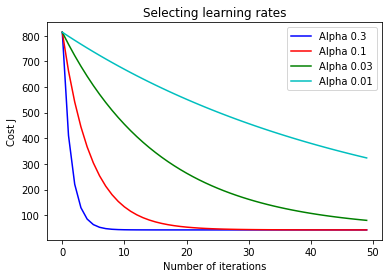

In [485]:
for i in range(0, len(alpha)):
    #theta = np.zeros(shape=(X.shape[1],1))
    theta, J_values = gradientDescent(X_norm, Y, alpha[i], num_iters)
    plt.plot(range(len(J_values)), J_values, colors[i], label='Alpha {}'.format(alpha[i]))
plt.xlabel('Number of iterations');
plt.ylabel('Cost J');
plt.title('Selecting learning rates');
plt.legend()
plt.show()

###Visualizing J(θ)

In [486]:
def pgradientDescent(X, Y, alpha, num_iters):
    m = X.shape[0]
    n=X.shape[1]
    theta = np.zeros((n+1,1))
    J_values = np.zeros(shape=(num_iters, 1))
    theta_values= np.zeros(shape=(num_iters, n+1))
    ones = np.ones((m,1))
    X = np.hstack((ones, X))
    Y = Y[:,np.newaxis]
    for i in range(num_iters):
        temp = np.dot(X, theta) - Y
        J_values[i] = np.sum(np.power(temp, 2)) / (2*m)
        theta_values[i]=theta.T
        temp = np.dot(X.T, temp)
        theta = theta - (alpha/m) * temp
        
    return theta_values, J_values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


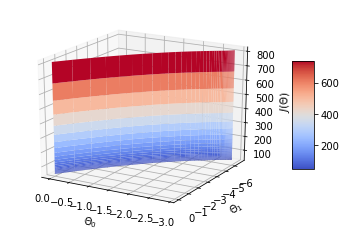

In [487]:
#Generating the surface plot
theta_values, J_values = pgradientDescent(X_norm, Y, 0.01, 500)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf=ax.plot_surface(theta_values[:,1],theta_values[:,2],J_values,cmap="coolwarm")
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel("$\Theta_0$")
ax.set_ylabel("$\Theta_1$")
ax.set_zlabel("$J(\Theta)$")
#rotate for better angle
ax.view_init(20,120)

###Plot the linear fit

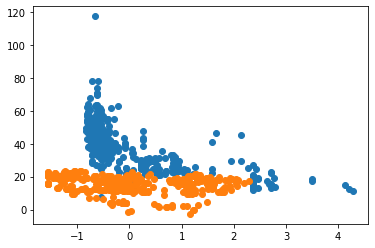

In [488]:
plt.scatter(X_norm[:,1], Y)
ones = np.ones((X.shape[0],1))
X_newnorm=[]
X_newnorm = np.hstack((ones, X_norm))
plt.scatter(X_newnorm[:,1], np.dot(X_newnorm, theta))
plt.show()